# Store Demand Forecasting
## Author github.com/tushar2704

# Table of contents
>[Importing Libraries](#scrollTo=d56c9940)

>[Exploring Data Analysis](#scrollTo=30510c91)

>[Feature Engineering](#scrollTo=490e899e)

>[Random Noise (Gürültü](#scrollTo=fb1e4bda)

>[Lag/Shifted Features (Gecikmeler)](#scrollTo=47f8ab82)

>[Rolling Mean Features (Hareketli Ortalamalar)](#scrollTo=b99cb837)

>[Exponentially Weighted Mean Features (Üssel Ağırlıklı Ortalama Featureları)](#scrollTo=6b9429d6)

>[LightGBM Model](#scrollTo=c75cb858)

>[Custom Cost Function](#scrollTo=c08b6548)



<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px;
color: Black; ">Store Item Demand Forecasting</span></h1>

**You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.**



<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px;
color: Black; ">Variables</span></h1>


- date
- store
- item
- sales



#Importing Libraries

In [ ]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

#Exploring Data Analysis

The code reads two CSV files, 'train.csv' and 'test.csv', and parses the 'date' column as dates during the reading process. It then concatenates the data from both files into a single DataFrame 'df', stacking them vertically. The 'head()' function is used to display the first few rows of the combined DataFrame.






In [ ]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


The code prints the dimensions (number of rows and columns) of the 'train' and 'test' DataFrames, showing the size of each dataset.






In [ ]:
print("Train setinin boyutu:",train.shape)
print("Test setinin boyutu:",test.shape)

Train setinin boyutu: (913000, 4)
Test setinin boyutu: (45000, 4)


In [ ]:
df.shape

(958000, 5)

The code calculates the quantiles (percentiles) of the data in the DataFrame 'df' for the specified quantile levels [0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]. It transposes the resulting DataFrame to display the quantiles for each column as rows.






In [ ]:
df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
store,1.0,1.00,3.00,5.5,8.00,10.00,10.00,10.0
item,1.0,3.00,13.00,25.5,38.00,48.00,50.00,50.0
sales,0.0,16.00,30.00,47.0,70.00,107.00,135.00,231.0
id,0.0,2249.95,11249.75,22499.5,33749.25,42749.05,44549.01,44999.0


In [ ]:
df["date"].min()

Timestamp('2013-01-01 00:00:00')

In [ ]:
df["date"].max()

Timestamp('2018-03-31 00:00:00')

The code calculates descriptive statistics for the 'sales' column in the DataFrame 'df', including mean, standard deviation, minimum, maximum, and percentiles at the specified quantile levels [0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99].






In [ ]:
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [ ]:
df["store"].nunique()

10

In [ ]:
df["item"].nunique()

50

The code groups the DataFrame 'df' by the "store" column and then calculates the number of unique items associated with each store in the dataset.






In [ ]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

The code groups the DataFrame 'df' by both the "store" and "item" columns, and then aggregates the "sales" column for each group, calculating the sum, mean, median, and standard deviation of sales for each combination of store and item in the dataset.






In [ ]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

#Feature Engineering

The code extracts various date-related features from the "date" column of the DataFrame 'df', such as month, day of the month, day of the year, week of the year, day of the week, and year. It also creates new binary features indicating whether the date is a weekend, month start, or month end.






In [ ]:
df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.weekofyear
df['day_of_week'] = df.date.dt.dayofweek
df['year'] = df.date.dt.year
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

In [ ]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


The code groups the DataFrame 'df' by the "store", "item", and "month" columns, and then aggregates the "sales" column for each combination of store, item, and month, calculating the sum, mean, median, and standard deviation of sales for each group.






In [ ]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

#Random Noise (Gürültü

The code defines a function 'random_noise' that takes a DataFrame as input and returns an array of random noise generated from a normal distribution with a scale of 1.6 and the same length as the input DataFrame.






In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

#Lag/Shifted Features (Gecikmeler)

The code sorts the DataFrame 'df' in place based on multiple columns, first by 'store', then by 'item', and finally by 'date' in ascending order. The 'head()' function is then used to display the first few rows of the sorted DataFrame.






In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


The code defines a function 'lag_features' that creates lagged features for the 'sales' column in the DataFrame 'df' by shifting the values by different time intervals specified in 'lags'. The function adds random noise to the shifted values and returns the updated DataFrame. The 'lag_features' function is then called with 'df' and a list of lag intervals to create the lagged features for the specified lags.






In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

#Rolling Mean Features (Hareketli Ortalamalar)

The code defines a function 'roll_mean_features' that calculates rolling mean features for the 'sales' column in the DataFrame 'df' using different rolling window sizes specified in 'windows'. The function applies the triangular rolling window with a minimum of 10 periods and adds random noise to the calculated rolling means. The updated DataFrame is then returned. The 'roll_mean_features' function is called with 'df' and a list of rolling window sizes to create the rolling mean features for the specified windows.






In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

#Exponentially Weighted Mean Features (Üssel Ağırlıklı Ortalama Featureları)

The code defines a function 'ewm_features' that calculates exponentially weighted moving average (EWMA) features for the 'sales' column in the DataFrame 'df' using different smoothing factors (alphas) and lag intervals specified in 'alphas' and 'lags', respectively. The function applies the EWMA to the lagged 'sales' data within each group defined by 'store' and 'item'. The updated DataFrame is then returned. The 'ewm_features' function is called with lists of alphas and lags to create the EWMA features for the specified combinations of smoothing factors and lag intervals, and the last few rows of the updated DataFrame are displayed using 'tail()'.






In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,39.989115,50.659809,66.905764,68.650074,68.397463,80.443281,79.043389,62.312828,96.881796,76.254367,86.116904,87.568055,81.850849,41.102494,53.993266,66.871500,67.862074,81.979884,112.096892,66.149794,96.496783,72.783196,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,61.001879,51.131267,65.967724,62.606243,75.032285,80.607704,80.034628,74.291420,81.862151,69.113428,86.057624,85.810530,83.169857,62.781025,51.029933,66.998715,60.078621,89.919799,118.930969,60.061498,80.164968,68.047832,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,60.715505,61.002341,67.009636,63.678228,72.611712,86.900464,79.191523,67.040461,100.416274,75.595312,87.229906,88.596201,79.991602,59.037810,62.880299,71.949987,65.940786,102.869198,119.989310,72.870615,98.811650,74.930478,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998

The code performs one-hot encoding on the 'day_of_week' and 'month' columns of the DataFrame 'df', creating binary columns for each unique value in these columns, effectively converting categorical variables into numerical format.






In [ ]:
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

The code applies the natural logarithm transformation (logarithm with base e) to the 'sales' column in the DataFrame 'df', using the numpy function 'np.log1p', which handles zero values gracefully by adding 1 before taking the logarithm. This transformation is often used to stabilize the variance and improve the performance of certain models.






In [ ]:
df['sales'] = np.log1p(df["sales"].values)

#LightGBM Model

The code creates two new DataFrames, 'train' and 'val', by filtering rows from the original DataFrame 'df' based on the dates. 'train' contains data before January 1, 2017, and 'val' contains data between January 1, 2017, and April 1, 2017. The variable 'cols' is defined as a list of column names from 'train' DataFrame, excluding the columns 'date', 'id', 'sales', and 'year'.






In [ ]:
train = df.loc[(df["date"] < "2017-01-01"), :]

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

The code creates four new variables: 'Y_train' and 'Y_val' are the target variables containing the 'sales' data for the training and validation sets, respectively. 'X_train' and 'X_val' are the feature matrices containing the selected columns (excluding 'date', 'id', 'sales', and 'year') for the training and validation sets, respectively. The final line displays the shapes of these arrays, indicating the number of rows and columns in each set.






In [ ]:
Y_train = train['sales']

X_train = train[cols]

Y_val = val['sales']

X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 94), (45000,), (45000, 94))

#Custom Cost Function

The code defines two functions: 'smape' calculates the Symmetric Mean Absolute Percentage Error (SMAPE) for two arrays of predictions and true target values, while 'lgbm_smape' computes SMAPE for LightGBM predictions by converting them back from log-scale using 'np.expm1' and comparing with the original labels.






In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

The code defines a dictionary 'lgb_params' containing various parameters for the LightGBM model, including the evaluation metric (Mean Absolute Error - 'mae'), number of leaves, learning rate, feature fraction, maximum depth, verbosity, number of boosting rounds, early stopping rounds, and the number of threads to use (-1 indicates using all available threads). These parameters will be used to configure the LightGBM model for training and evaluation.






In [ ]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 2000,
              'early_stopping_rounds': 200,
              'nthread': -1}

The code sets up the LightGBM datasets for training and validation ('lgbtrain' and 'lgbval') with specified features and labels. It then trains the LightGBM model using 'lgb_params' with early stopping based on the validation set, and evaluates the model's performance using SMAPE on the validation set, which is then calculated on the predicted target values ('y_pred_val') and the true target values ('Y_val').






In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.445511 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.171539	training's SMAPE: 17.4956	valid_1's l1: 0.170797	valid_1's SMAPE: 17.458
[200]	training's l1: 0.141262	training's SMAPE: 14.4691	valid_1's l1: 0.14515	valid_1's SMAPE: 14.8904
[300]	training's l1: 0.135658	training's SMAPE: 13.9075	valid_1's l1: 0.140024	valid_1's SMAPE: 14.376
[400]	training's l1: 0.13356	training's SMAPE: 13.6978	valid_1's l1: 0.138344	valid_1's SMAPE: 14.2078
[500]	training's l1: 0.132368	training's SMAPE: 13.5784	valid_1's l1: 0.137064	valid_1's SMAPE: 14.0792
[600]	training's l1: 0.131549	training's SMAPE: 13.4962	valid_1's l1: 0.135993	valid_1's SMAPE: 13.9714
[700]	training's l1: 0.130932	training's SMAPE: 13.4344	valid_1's l1: 0.135259	valid_1's SMAPE: 13.8975
[800]	training's l1: 0.130454	training's SMAPE: 1

13.62007233782973

The code separates the original DataFrame 'df' into the training set and the test set based on the presence of NaN values in the 'sales' column. It creates 'X_train' and 'X_test' as the feature matrices and 'Y_train' as the target variable containing non-NaN sales data for training.






In [ ]:
#Final Model

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

The code sets up LightGBM parameters in the 'lgb_params' dictionary and initializes the LightGBM dataset 'lgbtrain_all' using the entire training data. Then, it trains the LightGBM model on the full training data with 'lgb_params', using the optimal number of boosting rounds obtained from the earlier trained model ('model.best_iteration'). The model is then used to make predictions on the test set, and the results are stored in 'test_preds'.






In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.540060 seconds.
You can set `force_col_wise=true` to remove the overhead.


The code creates a DataFrame 'forecast' containing the predicted sales for each 'date', 'store', and 'item' in the test set based on the model's predictions ('test_preds'). Then, it filters the data for 'store' 1 and 'item' 1 from 'forecast', sets the 'date' column as the index, and plots the sales forecast for this specific store and item over time using Matplotlib, with the line color set to green and the specified figure size.






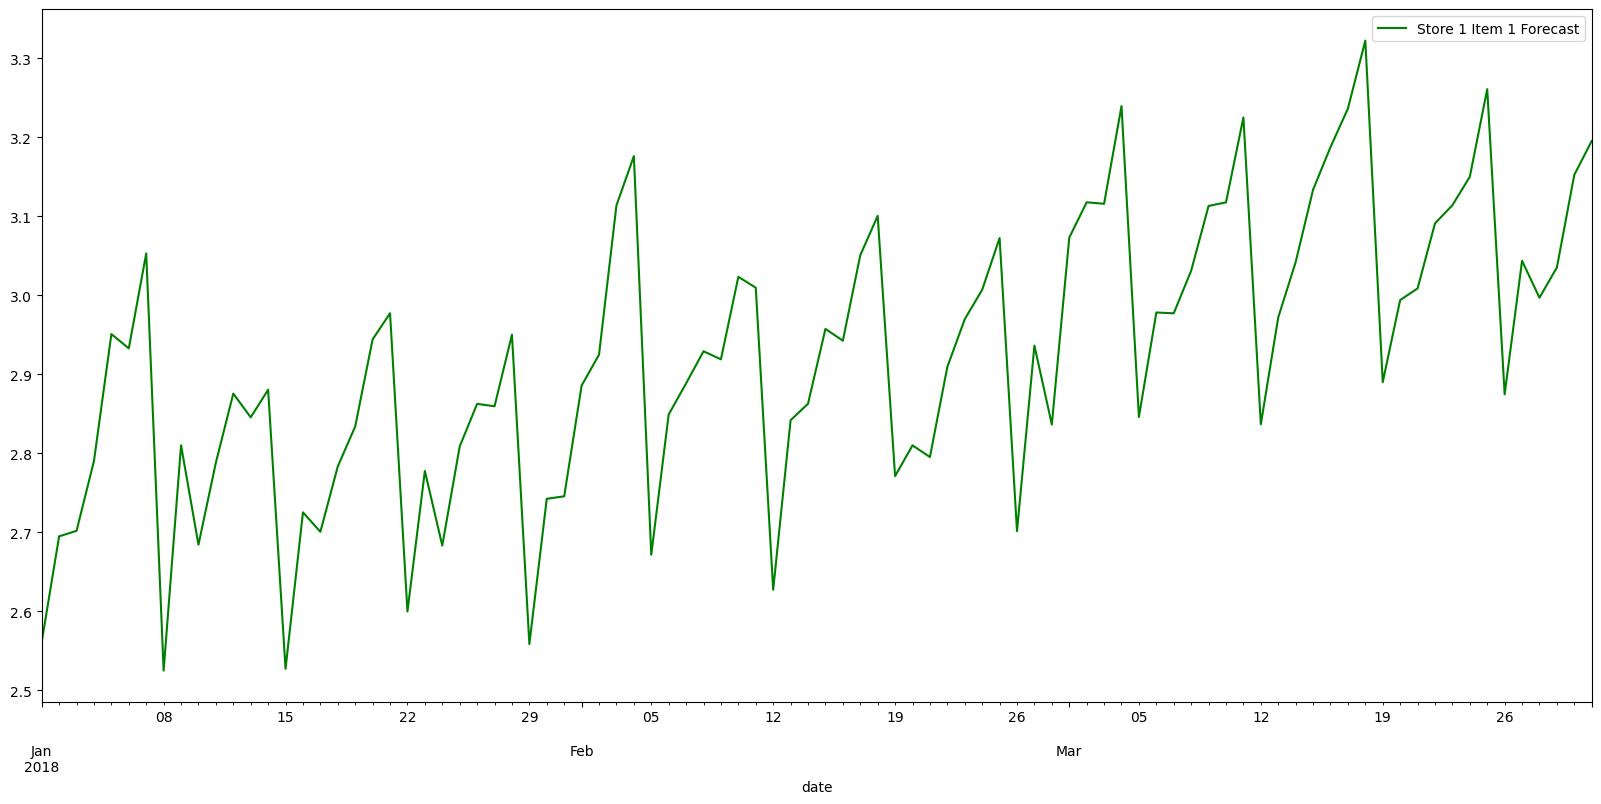

In [ ]:
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

The code first filters the 'train' DataFrame for 'store' 1 and 'item' 17, sets the 'date' column as the index, and plots the historical sales data for this specific store and item. Then, it does the same for the 'forecast' DataFrame, plotting the sales forecast for the same store and item. Both plots are displayed on the same graph, with different colors to distinguish between historical sales and sales forecast.






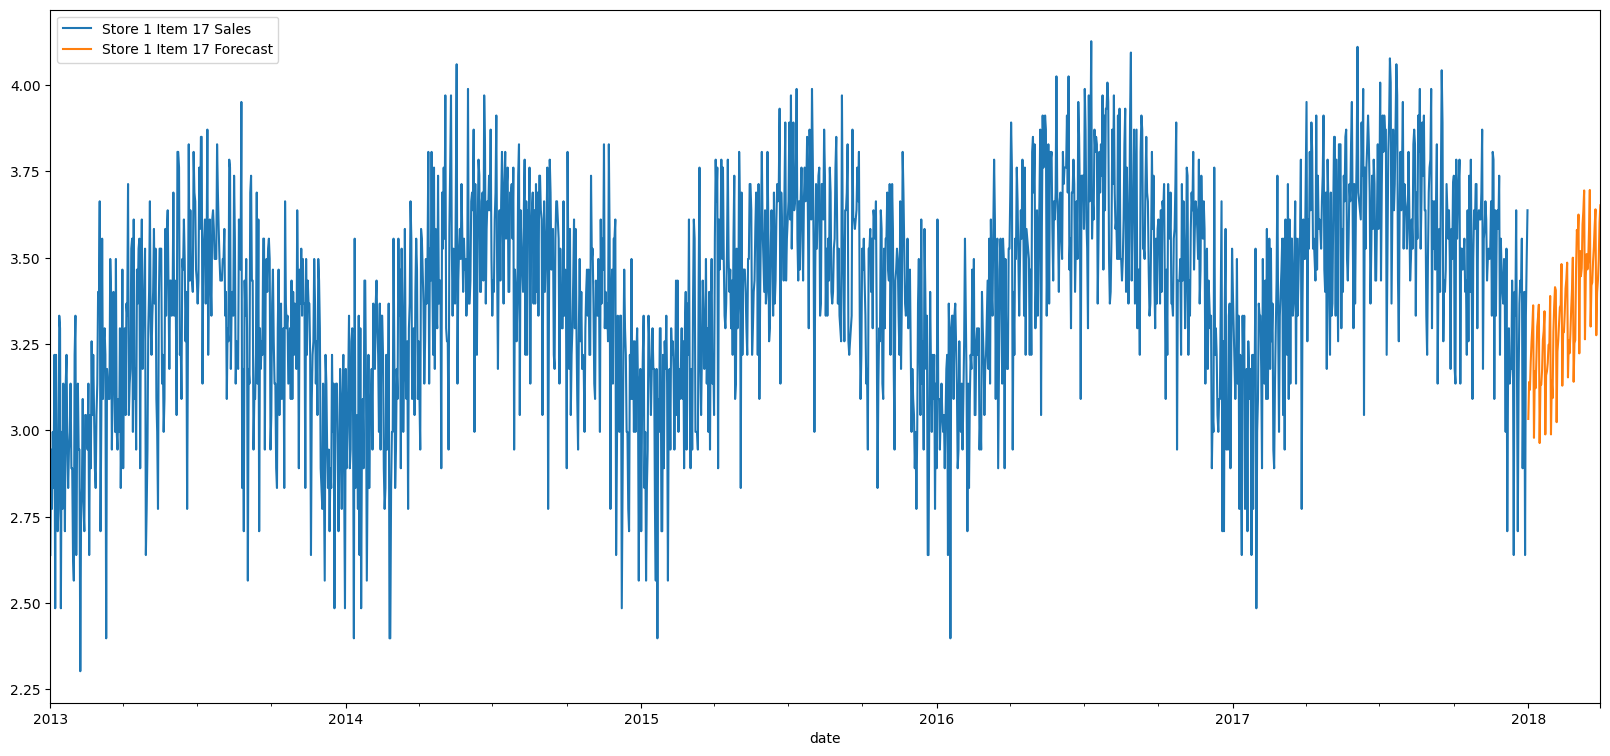

In [ ]:
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");

In [ ]:
df.shape

(958000, 98)